In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from tqdm import tqdm
import wandb
import os
import gym
from train_ppo import train_ppo
from models.ppo import PPO
from env.wei_obs_grid import WeightedObsGrid
from utils.utils import uniform_weight, normal_weight, NormalWeightGrid
import pickle
from baseline.dijkstra import dijkstra_grid_with_weights, reconstruct_path
import copy


## Load Env

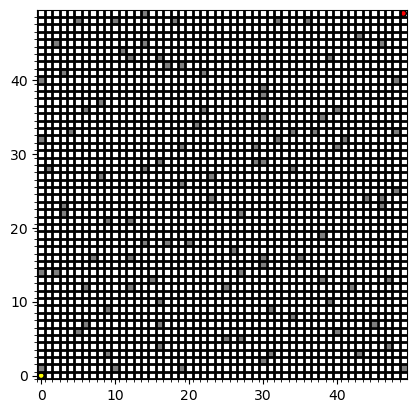

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [2]:
env = pickle.load(open('env.pkl', 'rb'))
env.render()
print(env.state['obstacles'])

In [3]:
#grid_wei = copy.deepcopy(env.wei_reset.get_mean_std()[0])
grid_wei = copy.deepcopy(env.state['weight'])
for i in env.obstacles:
    grid_wei[i] = float('inf')
start = env.goal
end = env.start
env.goal_set = None

In [11]:
def run_dijkstra(grid_wei, start, end):
    dis, pred = dijkstra_grid_with_weights(grid_wei,start,end)
    path = reconstruct_path(pred, end)
    path.reverse()
    return dis, path

## Load Model

In [5]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 5000
hidden_dim = 3
gamma = 0.9
epsilon = 0.2
lmbda = 0.9
epochs = 10
reset_interval = 5000
max_steps = 500
state_dim = (4, env.grid_size[0], env.grid_size[1])
action_dim = 4
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, epsilon, lmbda, epochs, device='cuda:0')
agent.load_state_dict(torch.load('saved_model/ppo_dijkstra.pth'))

<All keys matched successfully>

## Test Greedy-DRL

In [18]:
dijk_cost_list = []
ppo_cost_list = []
for _ in range(100):
    dis, path = run_dijkstra(grid_wei, start, end)
    
    for _ in range(5):
        done = False
        iter_num = 0
        ppo_cost = 0
        dijk_cost = 0
        state = env.reset()
        dijk_idx = 0
        while not done:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action_eval(state, eligibles,strategy='greedy')
            next_state, reward, done, _ = env.step(action)
            state = next_state

            ppo_cost += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
            if dijk_idx < len(path):
                dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
                dijk_idx += 1
        while dijk_idx < len(path):
            dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
            dijk_idx += 1
        dijk_cost_list.append(dijk_cost)
        ppo_cost_list.append(ppo_cost)


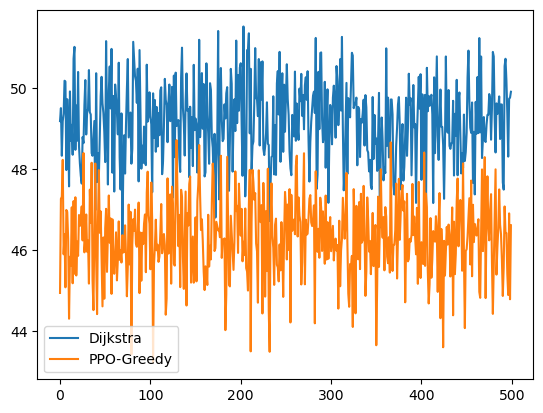

In [19]:
plt.plot(dijk_cost_list, label='Dijkstra')
plt.plot(ppo_cost_list, label='PPO-Greedy')
plt.legend()

In [22]:
import pandas as pd
df = pd.DataFrame({'Dijkstra': dijk_cost_list, 'PPO-Greedy': ppo_cost_list})
print(df.describe().to_markdown())

|       |   Dijkstra |   PPO-Greedy |
|:------|-----------:|-------------:|
| count |  500       |   500        |
| mean  |   49.1772  |    46.3042   |
| std   |    0.97793 |     0.964867 |
| min   |   46.2244  |    43.2216   |
| 25%   |   48.5177  |    45.6906   |
| 50%   |   49.22    |    46.3325   |
| 75%   |   49.8036  |    46.9448   |
| max   |   51.5196  |    48.7121   |


## Test Sample-DRL

In [23]:
dijk_cost_list = []
ppo_cost_list = []
for _ in range(100):
    dis, path = run_dijkstra(grid_wei, start, end)
    
    for _ in range(5):
        done = False
        iter_num = 0
        ppo_cost = 0
        dijk_cost = 0
        state = env.reset()
        dijk_idx = 0
        while not done:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action_eval(state, eligibles,strategy='greedy')
            next_state, reward, done, _ = env.step(action)
            state = next_state

            ppo_cost += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
            if dijk_idx < len(path):
                dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
                dijk_idx += 1
        while dijk_idx < len(path):
            dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
            dijk_idx += 1
        dijk_cost_list.append(dijk_cost)
        ppo_cost_list.append(ppo_cost)


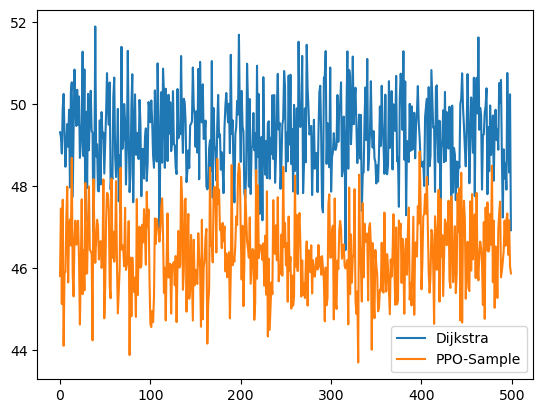

In [24]:
plt.plot(dijk_cost_list, label='Dijkstra')
plt.plot(ppo_cost_list, label='PPO-Sample')
plt.legend()

In [25]:
import pandas as pd
df = pd.DataFrame({'Dijkstra': dijk_cost_list, 'PPO-Sample': ppo_cost_list})
print(df.describe().to_markdown())

|       |   Dijkstra |   PPO-Sample |
|:------|-----------:|-------------:|
| count |  500       |   500        |
| mean  |   49.2686  |    46.3608   |
| std   |    0.96573 |     0.960747 |
| min   |   46.4374  |    43.6944   |
| 25%   |   48.5865  |    45.7388   |
| 50%   |   49.2611  |    46.2735   |
| 75%   |   49.9421  |    47.0325   |
| max   |   51.8907  |    48.8411   |
